# Collaborative filtering

To learn more about collaborative filtering and PyTorch, I'm going to derive an implementation based upon the ideas in [fastai book chapter 8](https://github.com/fastai/fastbook/blob/master/08_collab.ipynb) for user-movie-ratings from [MovieLens](https://grouplens.org/datasets/movielens/).

## Get some movie reviews

I will grab [a small subset](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip) and put into `data` subdir:

```
data/ml-latest-small
├── README.txt
├── links.csv
├── movies.csv
├── ratings.csv
└── tags.csv
```

"*Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).*" The `ratings.csv` file looks like:

```
userId,movieId,rating,timestamp
1,1,4.0,964982703
1,3,4.0,964981247
1,6,4.0,964982224
1,47,5.0,964983815
...
```

And, in case we are curious, `movies.csv` has:

```
movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
...
```

In [1]:
import pandas as pd
import torch  # Let's try this with PyTorch not numpy
# import numpy as np
import re
# np.set_printoptions(precision=2, suppress=True, linewidth=3000, threshold=20000)

def load(n = 10):
    df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
    df_ratings = df_ratings.drop('timestamp', axis=1)
    df_ratings = df_ratings.sample(n=n).reset_index(drop=True)
    # Merge in the title and genres
    df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
    df = df_ratings.merge(df_movies, on='movieId')
    # Strip the "(1999)" dates from the titles
    p = re.compile(r'[()0-9]+$')
    df['title'] = df['title'].map(lambda x: p.sub('', x).strip())
    return df

def compress_cats(df, colname):
    df[colname] = df[colname].astype('category').cat.as_ordered()
    df[colname] = df[colname].cat.codes # encode 0..n-1  NB: Different than I usually do (1..n)!!!!
    df[colname] = df[colname].astype(int)
    
def normal_transform(x, mean=0.0, std=0.01):
    "Convert x to have mean and std"
    return x*std + mean

def randn(n1, n2, device, dtype, mean=0.0, std=0.01, requires_grad=False):
    x = torch.randn(n1, n2, device=device, dtype=dtype)
    x = normal_transform(x, mean=mean, std=std)
    x.requires_grad=requires_grad
    return x

## Matrix of user x movie with ratings as elements

Let's create a matrix that maps user and movie to a rating. Most of the entries will be zero because not all users have seen all movies. We can start with just a few records so that we can see the entire matrix at once. Zeros in the matrix indicate that the user has not rated that movie. $R_{u,m}$ is rating for user $u$ and movie $m$.

In [2]:
df = load(n=6)
nmovies = len(df.groupby('movieId').count())
nusers = len(df.groupby('userId').count())
compress_cats(df, 'movieId') # make IDs 0..nmovies-1
compress_cats(df, 'userId')
df

userId  movieId  rating                                              title  \
0       4        5     3.0                No. 1 Ladies' Detective Agency, The   
1       5        0     3.0  Léon: The Professional (a.k.a. The Professiona...   
2       1        4     4.5                                    Couples Retreat   
3       3        3     2.5               Paris, I Love You (Paris, je t'aime)   
4       2        1     5.0                                     Producers, The   
5       0        2     3.5                          The Count of Monte Cristo   

                            genres  
0             Comedy|Crime|Mystery  
1      Action|Crime|Drama|Thriller  
2                   Comedy|Romance  
3                          Romance  
4                           Comedy  
5  Action|Adventure|Drama|Thriller

In [3]:
dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def R_matrix(df):
    nmovies = len(df.groupby('movieId').count())
    nusers = len(df.groupby('userId').count())
    R = torch.zeros(nusers, nmovies, device=device, dtype=dtype)
    for u,m,r,_,_ in df.values:
        R[u,m] = r  # user u and movie m get rating r
    return R

R = R_matrix(df)
R

tensor([[0.0000, 0.0000, 3.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 4.5000, 0.0000],
        [0.0000, 5.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 2.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.0000],
        [3.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0')

## Latent factors == dense embedding vectors

The goal is to replace the 0s with a predicted rating, just as I did when [creating the embeddings](catvar-embeddings-split-homebrew.ipynb), but this time we will do it with (probabilistic) matrix factorization. The idea is to conjure up two matrices whose matrix multiplication is our ratings matrix.  In other words, $U M^T = R$ for user matrix $U$ and movie matrix $M$. Let's say that we want 4 latent factors for each user and each movie, meaning that the dense embedding vectors are 4 dimensional. $U$ would then be nusers x 4 and $M$ would be nmovies x 4.  For the ith user and jth movie, $U_i \cdot M_j$ would represent the rating at $R_{i,j}$.

We initialize the user and movie embedding matrices randomly:

In [5]:
nfactors = 4
U = randn(nusers,  nfactors, device=device, dtype=dtype)
M = randn(nmovies, nfactors, device=device, dtype=dtype)
U

tensor([[ 0.0120, -0.0051, -0.0050,  0.0069],
        [-0.0008,  0.0115, -0.0207,  0.0146],
        [-0.0142,  0.0039,  0.0006,  0.0028],
        [-0.0159, -0.0056,  0.0107, -0.0085],
        [-0.0012,  0.0200,  0.0017,  0.0066],
        [-0.0250, -0.0084,  0.0148,  0.0012]], device='cuda:0')

Our first prediction is garbage but this explains the operation we want to perform to get a predicted $R$ matrix:

In [6]:
R_pred = U.mm(M.T)
R_pred

tensor([[-1.2926e-04, -3.4657e-05, -4.9852e-05,  2.2227e-04, -2.5469e-04,
         -2.4167e-04],
        [-4.5816e-04,  2.3424e-04, -3.2207e-04, -2.0926e-04, -6.5099e-04,
          6.5784e-05],
        [-3.6481e-06, -4.2695e-05, -8.8758e-05, -2.1768e-04,  1.5623e-04,
          1.9727e-04],
        [ 2.3774e-04, -1.6871e-04,  6.5009e-05, -1.5152e-04,  6.7952e-04,
          1.9141e-04],
        [ 9.7424e-06,  1.5835e-04,  5.2653e-05, -9.8577e-05, -5.7652e-04,
          1.3516e-04],
        [ 2.6007e-04, -3.9718e-04, -1.7386e-05, -1.4568e-04,  8.2772e-04,
          1.9245e-04]], device='cuda:0')

## Objective (loss) function

So those user and movie matrices are random and of course the resulting ratings are useless.  Understanding how good or bad they are is useful metric and of course what we will optimize to construct proper user and movie matrices. As a starting point, let's just look at the MSE:

In [7]:
loss = torch.mean( (R - R_pred).pow(2) )
loss

tensor(2.2710, device='cuda:0')

## Minimizing the loss function (gradient descent with momentum)

Let's do this using autograd and simple gradient descent (with momentum).

In [8]:
df = load(n=10_000)
compress_cats(df, 'movieId') # make IDs 0..nmovies-1
compress_cats(df, 'userId')

nmovies = len(df.groupby('movieId').count())
nusers = len(df.groupby('userId').count())
nfactors = 4

R = R_matrix(df)

U = randn(nusers,  nfactors, device=device, dtype=dtype, requires_grad=True)  # <-- track for autograd
M = randn(nmovies, nfactors, device=device, dtype=dtype, requires_grad=True)

In [9]:
learning_rate = 35
momentum = .01
for t in range(100):
    R_pred = U.mm(M.T) # predict ratings
    
    loss = torch.mean( (R - R_pred).pow(2) ) # compute objective function
    if t % 10 == 0:
        print(f"Epoch {t:3d} loss {loss:12.2f}")

    loss.backward() # autograd

    # Update weights; weights have requires_grad=True but we don't need to track these updates
    with torch.no_grad():
        U -= (momentum*U + learning_rate * U.grad)
        M -= (momentum*M + learning_rate * M.grad)

        U.grad.zero_() # reset gradients
        M.grad.zero_()

Epoch   0 loss         0.06
Epoch  10 loss         0.06
Epoch  20 loss         0.06
Epoch  30 loss         0.06
Epoch  40 loss         0.06
Epoch  50 loss         0.06
Epoch  60 loss         0.06
Epoch  70 loss         0.06
Epoch  80 loss         0.06
Epoch  90 loss         0.06


That says that the accuracy is very good so let's check it out.

## Check accuracy of embeddings via RF

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def RF_onehot(df, movie_embeddings, user_embeddings):
    X = df[['movieId','userId']]
    y = df['rating']
    X_emb = np.concatenate([movie_embeddings[X['movieId']],user_embeddings[X['userId']]], axis=1)
#     X_train, X_test, y_train, y_test = train_test_split(X_emb, y, test_size=0.2)

    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X_emb, y)
    print(f"OOB R^2 {rf.oob_score_:.3f}")
    print(f"Train R^2 {rf.score(X_emb, y):.3f}")
    # OOB seems close enough and much faster
#     scores = cross_val_score(rf, X_emb, y, cv=5)
#     print(f"5-fold valid R^2 {np.mean(scores):.3f}")

In [11]:
RF_onehot(df, M.cpu().detach().numpy(), U.cpu().detach().numpy())
#torch.cuda.is_available()

OOB R^2 0.086
Train R^2 0.874


Ok, so that accuracy is terrible, barely above guessing the average. What is going on?

## Loss should only consider nonzero ratings

Well, it seems that the matrix multiplication is the problem because $R$ it is mostly zeros. That means that we are training the vectors to get zeros in the missing spots, which is not what we want. Instead, the loss function needs to consider only the nonzero records. So rather than create $R$, let's just walk through the training records, which are the only non-zero values in the user x movie matrix. I asked [Yannet](https://www.usfca.edu/faculty/yannet-interian) and she confirmed for me that you want to avoid computing the loss on the zeros, which is also very expensive anyway. She said to focus just on the training records.

In [12]:
np.random.seed(1) # keep same records
df = load(n=10)
compress_cats(df, 'movieId') # make IDs 0..nmovies-1
compress_cats(df, 'userId')

nmovies = len(df.groupby('movieId').count())
nusers = len(df.groupby('userId').count())
nfactors = 4

U = randn(nusers,  nfactors, device=device, dtype=dtype, requires_grad=True)  # <-- track for autograd
M = randn(nmovies, nfactors, device=device, dtype=dtype, requires_grad=True)

In [13]:
U

tensor([[ 0.0005, -0.0078,  0.0109,  0.0065],
        [ 0.0110, -0.0148,  0.0051,  0.0129],
        [ 0.0199, -0.0061, -0.0108, -0.0203],
        [ 0.0011,  0.0015, -0.0002, -0.0104],
        [ 0.0081,  0.0067,  0.0143,  0.0009],
        [-0.0035,  0.0090,  0.0038, -0.0128],
        [ 0.0018, -0.0012,  0.0057, -0.0146],
        [ 0.0102,  0.0069, -0.0029,  0.0290],
        [ 0.0001, -0.0076, -0.0164,  0.0063],
        [-0.0116, -0.0175,  0.0087,  0.0004]], device='cuda:0',
       requires_grad=True)

In [14]:
M

tensor([[ 2.5760e-03,  1.9597e-03,  1.6345e-02,  1.2949e-02],
        [-1.1703e-03, -1.7760e-02,  3.0185e-03,  4.3748e-03],
        [-7.2257e-03,  2.7235e-03,  3.3684e-03, -2.0186e-03],
        [-9.1769e-03, -9.5161e-04,  1.0402e-02,  7.1008e-04],
        [ 2.2378e-03,  1.7578e-03, -3.4040e-03, -1.6663e-03],
        [ 5.2857e-03,  1.7193e-02,  2.9893e-03,  1.1353e-02],
        [ 7.0735e-03, -3.9242e-03,  1.4038e-02, -3.1308e-03],
        [-8.8216e-03, -6.9309e-03, -4.8633e-05, -1.4001e-02],
        [ 1.5138e-03, -7.9545e-04,  1.3443e-02, -6.4674e-03],
        [-4.4454e-03,  1.9103e-02,  2.0392e-03, -2.0167e-03]], device='cuda:0',
       requires_grad=True)

In [15]:
df.head(2)

userId  movieId  rating           title  \
0       4        1     3.0       True Lies   
1       8        8     5.0  Conjuring, The   

                                     genres  
0  Action|Adventure|Comedy|Romance|Thriller  
1                           Horror|Thriller

Looking at the first record, we see user 4 and movie 1, which we can use to select from the user and move the embeddings matrices:

In [16]:
U[4], M[1]

(tensor([0.0081, 0.0067, 0.0143, 0.0009], device='cuda:0',
        grad_fn=<SelectBackward>),
 tensor([-0.0012, -0.0178,  0.0030,  0.0044], device='cuda:0',
        grad_fn=<SelectBackward>))

Using those two vectors, their dot product is our predicted rating:

In [17]:
r_pred = U[4].dot(M[1])
r_pred

tensor(-8.1425e-05, device='cuda:0', grad_fn=<DotBackward>)

The loss associated with this one record is not good as we would expect given the random embeddings:

In [18]:
(df.iloc[0]['rating'] - r_pred).pow(2)

tensor(9.0005, device='cuda:0', grad_fn=<PowBackward0>)

If we want to do this with the first two records, we can use a list of user and movie IDs.For example, here are the user embeddings for the first two training records:

In [19]:
U[[4,8]]

tensor([[ 0.0081,  0.0067,  0.0143,  0.0009],
        [ 0.0001, -0.0076, -0.0164,  0.0063]], device='cuda:0',
       grad_fn=<IndexBackward>)

Now, we need the dot product for each vector in `U[[4,8]]` and `M[[1,8]]`, which is element-wise modification followed by a some, for for each record. We should get to numbers out of this:

In [20]:
U[[4,8]] * M[[1,8]]

tensor([[-9.4300e-06, -1.1919e-04,  4.3134e-05,  4.0629e-06],
        [ 1.8217e-07,  6.0800e-06, -2.2070e-04, -4.0885e-05]], device='cuda:0',
       grad_fn=<MulBackward0>)

In [21]:
(U[[4,8]] * M[[1,8]]).sum(axis=1)

tensor([-8.1425e-05, -2.5533e-04], device='cuda:0', grad_fn=<SumBackward1>)

The MSE is just the average squared difference of those two from the known rating:

In [22]:
diff = (U[[4,8]] * M[[1,8]]).sum(axis=1) - torch.tensor([3.0,5.0], device=device)
loss = torch.mean( diff.pow(2) )
loss

tensor(17.0015, device='cuda:0', grad_fn=<MeanBackward0>)

We could walk with a loop through the training values like this:

In [23]:
# slow
for u,m,r,_,_ in df.values[:5]:
    loss = (U[u].dot(U[m]) - r).pow(2)
    print(loss)

tensor(8.9996, device='cuda:0', grad_fn=<PowBackward0>)
tensor(24.9963, device='cuda:0', grad_fn=<PowBackward0>)
tensor(3.9991, device='cuda:0', grad_fn=<PowBackward0>)
tensor(24.9986, device='cuda:0', grad_fn=<PowBackward0>)
tensor(8.9995, device='cuda:0', grad_fn=<PowBackward0>)


But, the cool kids would vectorized this:

In [24]:
loss = torch.mean( (U[df['userId']] * M[df['movieId']]).sum(axis=1) )
loss

tensor(-6.5723e-05, device='cuda:0', grad_fn=<MeanBackward0>)

### Minimize loss just on training samples (new gradient descent)

In [25]:
df = load(n=20_000)
compress_cats(df, 'movieId') # make IDs 0..nmovies-1
compress_cats(df, 'userId')

nmovies = len(df.groupby('movieId').count())
nusers = len(df.groupby('userId').count())

In [26]:
U = randn(nusers,  nfactors, device=device, dtype=dtype, requires_grad=True)  # <-- track for autograd
M = randn(nmovies, nfactors, device=device, dtype=dtype, requires_grad=True)

nfactors = 4
learning_rate = 45
momentum = .015
for t in range(100):
    userIds = torch.tensor(df['userId'].values, device=device)
    movieIds = torch.tensor(df['movieId'].values, device=device)
    ratings = torch.tensor(df['rating'].values, device=device)
    diff = (U[userIds] * M[movieIds]).sum(axis=1) - torch.tensor(ratings)
    loss = torch.mean( diff.pow(2) )
    if t % 10 == 0:
        print(f"Epoch {t:3d} loss {loss:12.2f}")

    loss.backward() # autograd computes U.grad and M.grad

    # Update weights; weights have requires_grad=True but we don't need to track these updates
    with torch.no_grad():
        U -= (momentum*U + learning_rate * U.grad)
        M -= (momentum*M + learning_rate * M.grad)

        U.grad.zero_() # reset gradients
        M.grad.zero_()

Epoch   0 loss        13.35
Epoch  10 loss        13.34
Epoch  20 loss         7.34
Epoch  30 loss         2.11
Epoch  40 loss         1.21
Epoch  50 loss         0.92
Epoch  60 loss         0.97
Epoch  70 loss         1.16
Epoch  80 loss         1.11
Epoch  90 loss         1.10


/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


In [27]:
RF_onehot(df, M.detach().cpu(), U.detach().cpu())

OOB R^2 0.525
Train R^2 0.934


In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_comedy_drama_embeddings(df, movie_embeddings, xrange=(-.3,.3), yrange=(-.15,.15)):
    # get unique movie ID and title and genres
    df_movies = df.sort_values('movieId')[['movieId','title','genres']]
    df_movies = df_movies.drop_duplicates()
    df_movies = df_movies[(df_movies['genres']=='Comedy')|(df_movies['genres']=='Drama')]
    movie_embeddings = movie_embeddings[df_movies['movieId']]
    
    plt.figure(figsize=(5,5))
    movieIds = df_movies['movieId'].values
    genres = df_movies['genres'].values
    titles = df_movies['title'].values
    pca = PCA(n_components=2)
    vecs2D = pca.fit_transform(movie_embeddings)
    c = [('k' if genres[i]=='Comedy' else 'r') for i in range(len(vecs2D))]
    plt.scatter(vecs2D[:,0], vecs2D[:,1], c=c, s=5, alpha=.5)
    plt.xlim(*xrange)
    plt.ylim(*yrange)
    plt.show()
    return df_movies, vecs2D

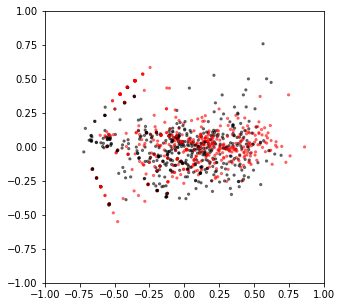

In [29]:
df_movies, vecs2D = plot_comedy_drama_embeddings(df, M.cpu().detach().numpy(), xrange=(-1,1), yrange=(-1.,1.))

### Learn to use bokeh

Derived from [Collaborative Filtering and Embeddings — Part 2 by Shikhar Gupta](https://towardsdatascience.com/collaborative-filtering-and-embeddings-part-2-919da17ecefb), alumnus of USFCA MSDS. :)  This pops up another window and hover shows title/genre.

In [30]:
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource

output_notebook() # send to notebook not tab

Loading BokehJS ...

In [31]:
data = dict(
    x=vecs2D[:,0],
    y=vecs2D[:,1],
    title = df_movies['title'],
    genre = df_movies['genres'],
    colors = [('black' if df_movies['genres'].iloc[i]=='Comedy' else 'red') for i in range(len(vecs2D))]
)
source = ColumnDataSource(data)

fig = figure(plot_width=1000, plot_height=600,
             title="Movie embeddings projected with PCA",
             tools="pan,wheel_zoom,zoom_in,box_zoom,reset,hover",
             x_axis_type=None, y_axis_type=None, min_border=1)

fig.scatter(x='x', y='y',source=source, fill_alpha=0.4, size=10, fill_color='colors')

# hover tools
hover = fig.select(dict(type=HoverTool))
hover.tooltips = {"content": "@title (@genre)"}

show(fig)

### Try limiting output to range 0..5

In [32]:
df = load(n=20_000)
compress_cats(df, 'movieId') # make IDs 0..nmovies-1
compress_cats(df, 'userId')

nmovies = len(df.groupby('movieId').count())
nusers = len(df.groupby('userId').count())

In [33]:
U = randn(nusers,  nfactors, device=device, dtype=dtype, requires_grad=True)  # <-- track for autograd
M = randn(nmovies, nfactors, device=device, dtype=dtype, requires_grad=True)

nfactors = 4
learning_rate = 200
momentum = .01
for t in range(500):
    userIds = torch.tensor(df['userId'].values, device=device)
    movieIds = torch.tensor(df['movieId'].values, device=device)
    ratings = torch.tensor(df['rating'].values, device=device)
    r_pred = (U[userIds] * M[movieIds]).sum(axis=1)
    r_pred = torch.sigmoid(r_pred) * 5  # limit to 0..5
    diff = r_pred - torch.tensor(ratings)
    loss = torch.mean( diff.pow(2) )
    if t % 30 == 0:
        print(f"Epoch {t:3d} loss {loss:12.2f}")

    loss.backward() # autograd computes U.grad and M.grad

    # Update weights; weights have requires_grad=True but we don't need to track these updates
    with torch.no_grad():
        U -= (momentum*U + learning_rate * U.grad)
        M -= (momentum*M + learning_rate * M.grad)

        U.grad.zero_() # reset gradients
        M.grad.zero_()

/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Epoch   0 loss         2.11
Epoch  30 loss         0.35
Epoch  60 loss         0.25
Epoch  90 loss         0.22
Epoch 120 loss         0.21
Epoch 150 loss         0.20
Epoch 180 loss         0.20
Epoch 210 loss         0.19
Epoch 240 loss         0.19
Epoch 270 loss         0.19
Epoch 300 loss         0.19
Epoch 330 loss         0.19
Epoch 360 loss         0.19
Epoch 390 loss         0.18
Epoch 420 loss         0.18
Epoch 450 loss         0.18
Epoch 480 loss         0.18


In [34]:
#RF_onehot(df, M.detach().numpy(), U.detach().numpy())
RF_onehot(df, M.detach().cpu(), U.detach().cpu())

OOB R^2 0.654
Train R^2 0.952


Seems to help a bit. 0.57 to 0.59 OOB R^2. Cool. increasing iterations to 500 and lr=50, moves to 0.64 OOB.

lr=200 and momentum=.01 gets 0.71 OOB R^2.

## Try with AdaGrad minimizer


In [35]:
df = load(n=20_000)
compress_cats(df, 'movieId') # make IDs 0..nmovies-1
compress_cats(df, 'userId')

nmovies = len(df.groupby('movieId').count())
nusers = len(df.groupby('userId').count())

In [36]:
nfactors = 16

U = randn(nusers,  nfactors, device=device, dtype=dtype, requires_grad=True)  # <-- track for autograd
M = randn(nmovies, nfactors, device=device, dtype=dtype, requires_grad=True)

learning_rate = .05
e = 0.0000001  # avoid division by zero when scaling learning rate

hU = torch.zeros(size=(nusers, nfactors),  device=device, dtype=dtype)
hM = torch.zeros(size=(nmovies, nfactors), device=device, dtype=dtype)
for t in range(800):
    userIds = torch.tensor(df['userId'].values, device=device)
    movieIds = torch.tensor(df['movieId'].values, device=device)
    ratings = torch.tensor(df['rating'].values, device=device)
    r_pred = (U[userIds] * M[movieIds]).sum(axis=1)
    r_pred = torch.sigmoid(r_pred) * 5  # limit to 0..5
    diff = r_pred - torch.tensor(ratings)
    loss = torch.mean( diff.pow(2) )
    if t % 50 == 0:
        print(f"Epoch {t:3d} loss {loss:12.2f}")

    loss.backward() # autograd computes U.grad and M.grad

    # Update weights; weights have requires_grad=True but we don't need to track these updates
    with torch.no_grad():
        hU += U.grad * U.grad
        hM += M.grad * M.grad
        U -= learning_rate * U.grad / (torch.sqrt(hU)+e)
        M -= learning_rate * M.grad / (torch.sqrt(hM)+e)

        U.grad.zero_() # reset gradients
        M.grad.zero_()

/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch   0 loss         2.09
Epoch  50 loss         0.10
Epoch 100 loss         0.05
Epoch 150 loss         0.03
Epoch 200 loss         0.02
Epoch 250 loss         0.02
Epoch 300 loss         0.01
Epoch 350 loss         0.01
Epoch 400 loss         0.01
Epoch 450 loss         0.01
Epoch 500 loss         0.01
Epoch 550 loss         0.01
Epoch 600 loss         0.01
Epoch 650 loss         0.01
Epoch 700 loss         0.01
Epoch 750 loss         0.01


In [37]:
RF_onehot(df, M.cpu().detach().numpy(), U.cpu().detach().numpy())

OOB R^2 0.560
Train R^2 0.939


This is very strange because the loss seems to go very very low and yet my random forest out of bag error is lower than when the loss is an order of magnitude bigger during training. hmm...

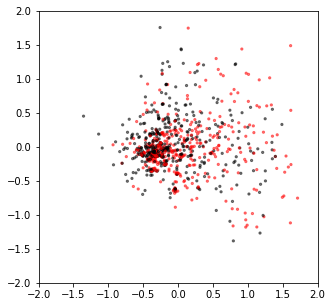

In [38]:
df_movies, vecs2D = plot_comedy_drama_embeddings(df, M.cpu().detach().numpy(), xrange=(-2,2), yrange=(-2,2))

## Let's add bias to embeddings

Much much slower, even on GPU. Still much faster than GPU though.

In [39]:
# if you run out of memory
torch.cuda.empty_cache()

In [40]:
df = load(n=15_000)
compress_cats(df, 'movieId') # make IDs 0..nmovies-1
compress_cats(df, 'userId')

nmovies = len(df.groupby('movieId').count())
nusers = len(df.groupby('userId').count())

In [41]:
%%time
nfactors = 4

U      = randn(nusers,  nfactors, device=device, dtype=dtype, requires_grad=True)
U_bias = randn(nusers,  1,        device=device, dtype=dtype, requires_grad=True)
M      = randn(nmovies, nfactors, device=device, dtype=dtype, requires_grad=True)
M_bias = randn(nmovies, 1,        device=device, dtype=dtype, requires_grad=True)

learning_rate = .01
e = 0.0000001  # avoid division by zero when scaling learning rate

# track gradient history
hU = torch.zeros(size=(nusers,  nfactors), device=device, dtype=dtype)
hM = torch.zeros(size=(nmovies, nfactors), device=device, dtype=dtype)
hU_bias = torch.zeros(size=(nusers,  1),   device=device, dtype=dtype)
hM_bias = torch.zeros(size=(nmovies, 1),   device=device, dtype=dtype)
for t in range(50):
    userIds = torch.tensor(df['userId'].values, device=device)
    movieIds = torch.tensor(df['movieId'].values, device=device)
    ratings = torch.tensor(df['rating'].values, device=device)
    r_pred = (U[userIds] * M[movieIds]).sum(axis=1, keepdim=True)  # keepdim says keep as shape (20_000,1) not (20_000,)
    r_pred += (U_bias[df['userId']] + M_bias[df['movieId']])
    r_pred = torch.sigmoid(r_pred) * 5  # limit to 0..5
    diff = r_pred - torch.tensor(ratings)
    loss = torch.mean( diff.pow(2) )
    if t % 5 == 0:
        print(f"Epoch {t:3d} loss {loss:12.2f}")

    loss.backward() # autograd computes U.grad and M.grad

    # Update weights; weights have requires_grad=True but we don't need to track these updates
    with torch.no_grad():
        hU += U.grad * U.grad
        hM += M.grad * M.grad
        hU_bias += U_bias.grad * U_bias.grad
        hM_bias += M_bias.grad * M_bias.grad
        U -= learning_rate * U.grad / (torch.sqrt(hU)+e)
        M -= learning_rate * M.grad / (torch.sqrt(hM)+e)
        U_bias -= learning_rate * U_bias.grad / (torch.sqrt(hU_bias)+e)
        M_bias -= learning_rate * M_bias.grad / (torch.sqrt(hM_bias)+e)

        U.grad.zero_() # reset gradients
        M.grad.zero_()
        U_bias.grad.zero_() # reset gradients
        M_bias.grad.zero_()

/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch   0 loss         2.08
Epoch   5 loss         1.92
Epoch  10 loss         1.83
Epoch  15 loss         1.76
Epoch  20 loss         1.69
Epoch  25 loss         1.64
Epoch  30 loss         1.59
Epoch  35 loss         1.55
Epoch  40 loss         1.51
Epoch  45 loss         1.47
CPU times: user 23.7 s, sys: 473 ms, total: 24.2 s
Wall time: 24.1 s


In [42]:
RF_onehot(df, M.cpu().detach().numpy(), U.cpu().detach().numpy())

OOB R^2 0.123
Train R^2 0.879


## Simple momentum but add bias, properly initializing weights

Faster than full AdaGrad.  Also drop to 10k records for speed. Ok, still bad with bias. Yannet suggests better initialization.

### Initializing weights

See [Initializing neural networks](https://www.deeplearning.ai/ai-notes/initialization/). Let's say we have user 4 and movie 1.  The resulting rating prediction is the dot product of the two embedding vectors:

In [82]:
df = load(n=10_000)
compress_cats(df, 'movieId') # make IDs 0..nmovies-1
compress_cats(df, 'userId')

nmovies = len(df.groupby('movieId').count())
nusers = len(df.groupby('userId').count())

In [83]:
nfactors = 4
U      = randn(nusers,  nfactors, device=device, dtype=dtype, requires_grad=True)
M      = randn(nmovies, nfactors, device=device, dtype=dtype, requires_grad=True)
U[4], M[1]

(tensor([-0.0073, -0.0122,  0.0020,  0.0160], device='cuda:0',
        grad_fn=<SelectBackward>),
 tensor([ 0.0148, -0.0172,  0.0087, -0.0065], device='cuda:0',
        grad_fn=<SelectBackward>))

Yannet says we want that average value for the dot product to be about 2.5 (roughly halfway between 0 and 5). The dot product is $\sum_{i=1}^{nfactors} U_i M_i$. In this case we are using nfactors=4, which means we are adding the multi-location of 4 pairs of numbers. We want that some of products to centered around 2.5. We have chosen the random numbers to be centered at 0 (with standard deviation 0.01) by default. From [these notes](https://www.kellogg.northwestern.edu/faculty/weber/emp/_session_0/Probability.pdf), the expected value of a+b is the expected value of a plus the expected value of b;  the expected value of a x b is the expected value of a times the expected value of b **if** a and b our independent, which they are.  So each element (product) of the summation needs to be about 2.5/nfactors on average so that the sum is 2.5. Each operand of the product a x b must be sqrt(2.5/nfactors) on average, which is about 0.55.

In [99]:
import math
U      = randn(nusers,  nfactors, device=device, dtype=dtype, requires_grad=True, mean=math.sqrt(2.5/nfactors))
M      = randn(nmovies, nfactors, device=device, dtype=dtype, requires_grad=True, mean=math.sqrt(2.5/nfactors))

In [100]:
U.shape, M.shape, nusers, nmovies

(torch.Size([593, 8]), torch.Size([3601, 8]), 593, 3601)

Mean of prediction from random user and movie matrices is 2.4993679523468018


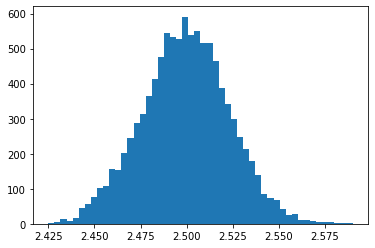

In [101]:
userIds = torch.tensor(df['userId'].values, device=device)
movieIds = torch.tensor(df['movieId'].values, device=device)
ratings = torch.tensor(df['rating'].values, device=device)
r_pred = (U[userIds] * M[movieIds]).sum(axis=1, keepdim=True)
print(f"Mean of prediction from random user and movie matrices is {torch.mean(r_pred)}")
r_pred = r_pred.cpu().detach().numpy()
plt.hist(r_pred, bins=50)
plt.show()

For the bias, we need the average value of the sum of biases to be about 2.5, so we should use 2.5/nfactors for the average during initialization of biases.

### Momentum model with mean shifted for initialization

In [ ]:
nfactors = 4

U      = randn(nusers,  nfactors, device=device, dtype=dtype, requires_grad=True, mean=math.sqrt(2.5/nfactors))
U_bias = randn(nusers,  1,        device=device, dtype=dtype, requires_grad=True, mean=2.5/nfactors)
M      = randn(nmovies, nfactors, device=device, dtype=dtype, requires_grad=True, mean=math.sqrt(2.5/nfactors))
M_bias = randn(nmovies, 1,        device=device, dtype=dtype, requires_grad=True, mean=2.5/nfactors)

learning_rate = 1
momentum = .0
for t in range(200):
    userIds = torch.tensor(df['userId'].values, device=device)
    movieIds = torch.tensor(df['movieId'].values, device=device)
    ratings = torch.tensor(df['rating'].values, device=device)
    r_pred = (U[userIds] * M[movieIds]).sum(axis=1, keepdim=True)
    r_pred = torch.sigmoid(r_pred) * 5  # limit to 0..5
    r_pred += (U_bias[df['userId']] + M_bias[df['movieId']])
    diff = r_pred - torch.tensor(ratings)
    loss = torch.mean( diff.pow(2) )
    if t % 5 == 0:
        print(f"Epoch {t:3d} loss {loss:12.2f}")

    loss.backward() # autograd computes U.grad and M.grad

    # Update weights; weights have requires_grad=True but we don't need to track these updates
    with torch.no_grad():
        U -= (momentum*U + learning_rate * U.grad)
        M -= (momentum*M + learning_rate * M.grad)
        U_bias -= (momentum*U_bias + learning_rate * U_bias.grad)
        M_bias -= (momentum*M_bias + learning_rate * M_bias.grad)

        U.grad.zero_() # reset gradients
        M.grad.zero_()
        U_bias.grad.zero_() # reset gradients
        M_bias.grad.zero_()        

/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch   0 loss         6.74
Epoch   5 loss         5.84
Epoch  10 loss         5.13
Epoch  15 loss         4.58
Epoch  20 loss         4.15
Epoch  25 loss         3.80
Epoch  30 loss         3.51
Epoch  35 loss         3.27
Epoch  40 loss         3.07
Epoch  45 loss         2.89
Epoch  50 loss         2.74
Epoch  55 loss         2.62
Epoch  60 loss         2.50
Epoch  65 loss         2.40
Epoch  70 loss         2.32
Epoch  75 loss         2.24
Epoch  80 loss         2.17
Epoch  85 loss         2.10
Epoch  90 loss         2.05
Epoch  95 loss         2.00
Epoch 100 loss         1.95
Epoch 105 loss         1.91
Epoch 110 loss         1.87
Epoch 115 loss         1.83
Epoch 120 loss         1.80
Epoch 125 loss         1.77
Epoch 130 loss         1.74
Epoch 135 loss         1.72
Epoch 140 loss         1.70
Epoch 145 loss         1.67
Epoch 150 loss         1.65
Epoch 155 loss         1.63
Epoch 160 loss         1.62


In [ ]:
#RF_onehot(df, M.detach().numpy(), U.detach().numpy())
RF_onehot(df, M.detach().cpu(), U.detach().cpu())

In [ ]:
df_movies, vecs2D = plot_comedy_drama_embeddings(df, M.cpu().detach().numpy(), xrange=(-.25,.25), yrange=(-.1,.1))